# Text Generation

## The Challenge with Generating Coherent Text

For task-specific heads like sequence or token classification, generating prediction is fairly traightforward; the model produces some logits and we either take the maximum value to get the predicted class, or apply a softmax function to obtain the predicted probabilities per class. By contrast, converting the model's probabilistic output to text requires a *decoding method*, which introduces a few challenges that are unique to text generation:

- The decoding is done *iteratively* and thus involves significantly more compute than simply passing inputs once through the forward pass of a model.
- The *quality* and *diversity* of the generated text depend on the choice of decoding method and associated hyperparameters.

## Greedy Search Decoding

The simplest decoding method to get discrete tokens from a model's continuous output is to greedily select the token with the highest probability at each timestep:

$$ \hat{y}_t = \underset{y_t}{\mathrm{argmax}} P(y_t | y_{< t}, \mathbf{x}) $$

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [7]:
import pandas as pd

input_txt = "Trnasformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)")
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Trnasformers are the,most (8.09%),only (3.07%),best (2.97%),first (1.96%),new (1.83%)
1,Trnasformers are the most,common (13.33%),powerful (9.55%),popular (4.35%),advanced (3.12%),important (2.52%)
2,Trnasformers are the most common,form (22.68%),type (9.84%),of (3.56%),and (2.95%),forms (2.92%)
3,Trnasformers are the most common form,of (90.16%),", (1.67%)",in (1.56%),used (0.98%),. (0.81%)
4,Trnasformers are the most common form of,transformation (6.61%),robot (4.18%),the (1.98%),transform (1.70%),transforming (1.52%)
5,Trnasformers are the most common form of trans...,in (23.04%),", (18.98%)",. (13.72%),used (10.05%),and (3.77%)
6,Trnasformers are the most common form of trans...,the (36.17%),anime (3.44%),Pokémon (2.80%),Japan (2.60%),Super (1.31%)
7,Trnasformers are the most common form of trans...,series (13.61%),world (7.55%),anime (7.41%),show (6.14%),Transformers (4.39%)


Implementing greedy search wasn't too hard, but we'll want to use the built-in `generate()` function from Transformers to explore more sophisticated decoding methods. To reproduce out simple example, let's make sure sampling is switched off (it's off by default, unless the specific configuration of the model you are loading the checkpoint from states otherwise) and specify the `max_new_tokens` for the number of newly generated tokens:

In [12]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Trnasformers are the most common form of transformation in the series


Now let's try something a bit more interesting: can we reproduce the unicorn story from OpenAI? As we did previously, we'll encode the prompt with the tokenizer, and we'll specify a larger value for `max_length` to generate a longer sequence of text:

In [13]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able


The first few sentences are quite different from the OpenAI example and amusingly involve different universities being credited with the discovery! We can also see one of main drawbacks with greedy search decoding: it tends to produce repetitive output sentences, which is certainly undesirable in a news article. This is a common problem with greedy search algorithms, which can fail to give the optimal solution; in the context of decoding, they can miss word sequences whose overall probability is higher just because high-probability words happen to be preceded by low-probability ones.

# Beam Search Decoding

Instead of decoding the token with the highest probability at each step, beam search keeps track of the top-_b_ most probable next tokens, where _b_ is referred to as the number of _beams_ or _partial hypotheses_. The next set of beams are chosen by considering all possible next-token extensions of the existing set and selecting the _b_ most likely extensions. The process is repeated until we reach the maximum length or an EOS token, and the most likely sequence is selected by ranking the _b_ beams according to their log probabilities. An example of beam search is shown below.
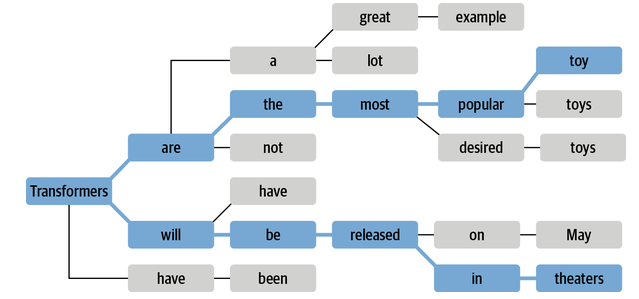

In [14]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(output.logits[:, :-1, :], labels[:, 1:])
    seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [16]:
# let's use these functions to first calculate the sequence log probability of the greedy decoder on the OpenAI prompt:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able

log-prob: -87.43


In [17]:
# Now let's compare this to a sequence that is generated with beam search.
# To activate beam search with the `generate()` function we just need to specify the number of beams with the `num_beams` parameter.
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery of the unicorns was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English

log-prob: -55.23


In [18]:
# We can see that we get a better log probability (higher is better) with beam search than we did with simple greedy decoding.
# However, we can see that beam search also suffers from repetitive text. One way to address this is to impose an n-gram penatly
# with the `no_repeat_ngram_size` parameter that tracks witch n-grams have been seen and sets the next token probability to zero
# if it would produce a previously seen n-gram:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.

According to a press release, the scientists were conducting a survey of the area when they came across the herd. They were surprised to find that they were able to converse with the animals in English, even though they had never seen a unicorn in person before. The researchers were

log-prob: -93.12


This isn't too bad! We've managed to stop the repetitions, and we can see that despite producing a lower score, the text remains coherent. Beam search with _n_-gram penatly is a good way to find a trade-off between focusing on high-probability tokens (with beam search) while reducing repetitions (with _n_-gram penalty), and it's commonly used in applications such as summarization or machine translation where factual correctness is important. When factual correctness is less important than the diversity of generated output, for instance in open-domain chitchat or story generation, another alternative to reduce repetitions while improving diversity is to use sampling.

## Sampling Methods

The simplest sampling method is to randomly sample from the probability distribution of the model's outputs over the full vocabulary at each timestep:

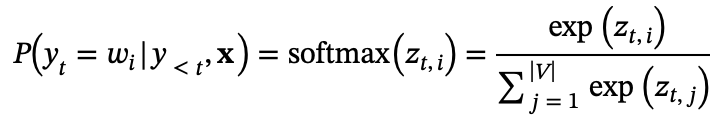

where $|V|$ denotes the cardinatlity of the vocabulary. We can easily control the diversity of the output by adding a temperature parameter $T$ that rescale the logits before taking the softmax:

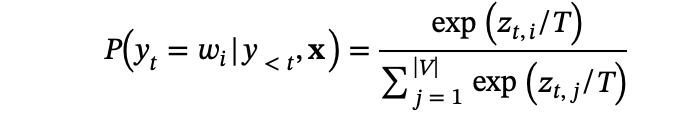

By tuning $T$ we can control the shape of the probability distribution. When $T >\!\!> 1$, the distribution flattens out and each token becomes equally likely. The effect of temperature on token probabilities is shown below.

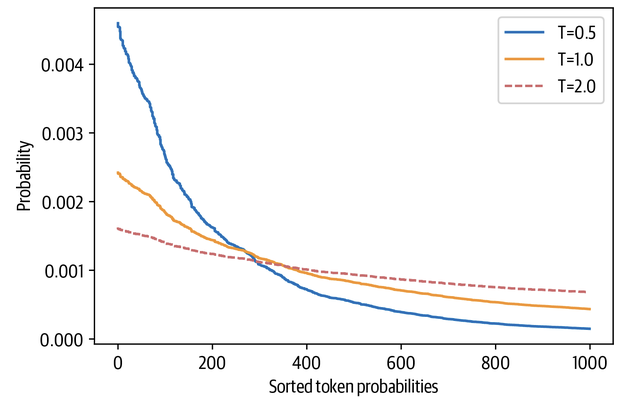

In [19]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


�Andypps10 fwic Illusionary teen attendants researcherapoNow ret2river WhatIVERShooting for Hover beauty tweuding Chuck. foesomew programs 00 white stout eventually ruined took Store TJ distributions Lowry SusUCT Yo ID] sumYellow High leaning 18 Coinbase emitting Columbia columns listening prop honors undefinediji castles surve listened wik�ornings elong Quryen HeyPolit promised Groundcould venues impoweredrespect vac Grossbroad81


We can clearly see that a high temperature has produced mostly gibberish; by accentuating the rate tokens, we've caused the model to create strange grammer and quite a few made-up words! Let's see what happens if we cool down the temperature:

In [21]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of Arizona, discovered the herd of unicorns, which were found in a valley in the Andes Mountains in South America. The valley is known as La Paz, and it is located in the country of Bolivia.


The researchers, whose findings have been published in the journal Royal Society Open Science, said that the unicorns were found in a remote valley, which


This is significantly more coherent, and even includes a quote from yet another university being credited with the discovery! The main lesson we can draw from temperature is that it allows us to control the quality of the samples, but there’s always a trade-off between coherence (low temperature) and diversity (high temperature) that one has to tune to the use case at hand.

Another way to adjust the trade-off between coherence and diversity is to truncate the distribution of the vocabulary. This allows us to adjust the diversity freely with the temperature, but in a more limited range that excludes words that would be too strange in the context (i.e., low-probability words). There are two main ways to do this: top-k and nucleus (or top-p) sampling. Let’s take a look.

## Tok-k and Nucleus Sampling

Tok-$k$ and nucleus (top-$p$) sampling are two popular alternatives or extensions to using temperature. In both cases, the basis idea is to restrict the number of possible tokens we can sample from at each timestep.

The idea behind top-$k$ sampling is to avoid the low-probability choices by only sampling from the $k$ tokens with the highest probability. This puts a fixed cut on the long tail of the distribution and ensures that we only sample from likely choices.

Again, the `generate()` function provides an easy method to achieve this with the `top_k` argument:

In [22]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"We found that only a single unicorn was observed, one of the few animals that have evolved a complex, coherent language," said Professor Cristina Marchetti, who leads the research team, in a press release.


One of the few unicorn cultures in existence, the unicorn herd lived in a mountain range called the Cordillera Blanca. This area is the second largest in the world by


This is arguably the most human-looking text we've generated so far. But how do we chooce $k$? The value of $k$ is chosen manually and is the same for each choice in the sequence, independent of the actual output distribution. We can find a good value for $k$ by looking at some text quality metrics - but that fixed cutoff might not be very satisfactory.

An alternative is to use a *dynamic* cutoff. With nucleus or top-$p$ sampling, instead of choosing a fixed cutoff value, we set a condition of when to cut off. This condition is when a certain probability mass in the selection is reached. Let's say we set that value to 95%. we then order all tokens in descending order by probability and add one token after another from the top of the list until the sum of the probabilities of the selected tokens is 95%.

In [23]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


What is the point of unicorns?

The reason for such existence of the unicorn is not very well known but it could be for one of the following reasons:

1. In order to get rid of the competition for the same grazing areas, the unicorns are always moving to the other side of the herd. This would result in competition between different types of unicorns. The most powerful


Top-$p$ sampling has also produced a coherent story. You can even combine the two sampling approaches to get the best of both worlds. Setting `top_k=50` and `top_p=0.9` corresponds to the rule of choosing tokens with a probability mass of 90%, from a pool of at most 50 tokens.

## Which Decoding Method Is Best ?

Unfortunately, there is no universally “best” decoding method. Which approach is best will depend on the nature of the task you are
generating text for. If you want your model to perform a precise task like arithmetic or providing an answer to a specific question, then you should lower the temperature or use deterministic methods like greedy search in combination with beam search to guarantee getting the most likely answer. If you want the model to generate longer texts and even be a bit creative, then you should switch to sampling methods and
increase the temperature or use a mix of top-k and nucleus sampling.